# First Year Project
## Project 3 - Effectiveness of Skin Cancer Prediction

This notebook contains all of the code developed for project 3, completing tasks similar to data scientists working for a dermatologist to investigate whether some characteristics of skin lesions can be reliably measure with a smartphone app.

The goal is to measure at least 2 of the following characteristics in a set of skin lesion images; asymmetry, border, and color.

Then, we will try to assess how good the measurements are, by predicting the diagnosis of the skin lesions based on these features.

We will focus on the **Melanoma** form of skin cancer.

Group 3:<br>
Crisanna Cornish (ccor@itu.dk)<br>
Danielle Dequin (ddeq@itu.dk)<br>
Gino Franco Fazzi (gifa@itu.dk)<br>
Moneeca Abru Iftikhar Latif (abml@itu.dk)<br>
Carl August Wismer (cwis@itu.dk)

Created: 07-04-2021<br>
Last Modified: 18-04-2021

# Data Sources

Data was provided by the ISIC challenge data sets. <br>
https://challenge.isic-archive.com/data

Codella N, Gutman D, Celebi ME, Helba B, Marchetti MA, Dusza S, Kalloo A, Liopyris K, Mishra N, Kittler H, Halpern A. "Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)". arXiv: 1710.05006 [cs.CV]


# Imports

Libraries used in this notebook.

In [2]:
#Basic libraries for array calculations and dataframes
import math
import numpy as np
import pandas as pd
from scipy import stats
#Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#Image processing
import skimage
from skimage.transform import rotate
from skimage import morphology
from skimage import measure
#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report,\
confusion_matrix, accuracy_score, plot_confusion_matrix, recall_score

# Constants

Constants to access data on the directory structure of this repository.

In [3]:
TRAIN = './data/training/' 
VALID = './data/validation/'
TEST = './data/test/'

IMG = 'example_image/'
SEG = 'example_segmentation/'
FEAT = 'features/'
TRUTH = 'ground_truth.csv'


# Functions

Functions created for this notebook.

In [4]:
"""FUNCTIONS FOR MASKED IMAGES"""

def get_boundaries(image):
    """Function to locate the boundaries of the lesion over the whole image.
    Takes a segmentation mask image as argument and returns the upper, lower, left and right boundaries."""

    mask = np.where(image == 1)
    left = min(mask[1])
    right = max(mask[1])
    upper = min(mask[0])
    lower = max(mask[0])
    return upper, lower, left, right

def get_center(image): # NOT NEEDED ANYMORE ?
    """Function that takes an image as input, and returns the centerpoint of the lesion."""
    up, dw, lt, rt = get_boundaries(image)
    center = ((up+dw)/2, (lt+rt)/2)
    return center
    
def zoom(image):
    """Function to zoom-in (crop) the lesion from blank space. Takes a segmentation mask image as input,
    and returns the rectangle where the lesion is found."""

    up, dw, lt, rt = get_boundaries(image)
    rectangle = image[up:dw+1, lt:rt+1]
    return rectangle

def cuts(image):
    """Function to perform a double cut (vertical and horizontal) of the lesion. Takes a segmentation mask image as input,
    and returns the vertical and horizontal cuts (2 for each dimension). It handles uneven shapes."""

    center_h = image.shape[0] // 2 # The image shape contains a tuple with height and width (in pixels)
    if image.shape[0] % 2 == 0: # If the height is an even number of pixels, the cut returns 2 equal sides
        upside = image[:center_h,:]
        downside = image[center_h:,:]
    else: # If the height is an uneven number of pixels, the cut has to "share" the center, to return 2 equal sides
        upside = image[:center_h,:]
        downside = image[center_h+1:,:]
        
    center_w = image.shape[1] // 2    
    if image.shape[1] % 2 == 0:
        leftside = image[:,:center_w]
        rightside = image[:,center_w:]
    else:
        leftside = image[:,:center_w]
        rightside = image[:,center_w+1:]
    return upside, downside, leftside, rightside


def test_symmetry(image, rot_deg=5):
    """Function to test the symmetry of an image. Takes a segmentation mask image and
    the rotation degree interval and returns a symmetry score between zero (non-symmetric)
    to one (completely symmetric)."""

    assert (rot_deg <= 90) and (rot_deg >= 0), "Rotation degree should be positive and at most 90 deg"
    optimal = 0
    
    for deg in range(0,91, rot_deg):
        rot_image = skimage.transform.rotate(image, deg, resize=True)
        z = zoom(rot_image)
        
        upside, downside, leftside, rightside = cuts(z)

        up_dw = np.sum(np.bitwise_and(upside.astype(int), np.flipud(downside).astype(int))) /\
        np.sum(np.bitwise_or(upside.astype(int), np.flipud(downside).astype(int)))

        lt_rt = np.sum(np.bitwise_and(leftside.astype(int), np.fliplr(rightside).astype(int))) /\
        np.sum(np.bitwise_or(leftside.astype(int), np.fliplr(rightside).astype(int)))
    
        symmetry = (up_dw+lt_rt)/2
        
        if symmetry > optimal: optimal = symmetry

    return symmetry
    
def rgb2gray(rgb):
    """Function to convert a RGB image to grayscale."""
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def crop(image, mask, resize=True, warning=True):
    """
    Function to crop an image. It takes a color image and its segmented mask as arguments and returns
    a new image where the lesion is present in color, and the background is empty.
    The resize argument (True by default) will reduce the image to the minimum rectangle containing the
    lesion.
    The warning argument (True by default) will raise an exception if the image and the mask don't have
    the same dimensions.
    """
    if image.shape[:2] != mask.shape[:2]:
        if warning:
            print("Image and Mask must have the same size. OPERATION CANCELLED.")
        else: return
    else:
        img = image.copy()
        img[mask==0] = 0

        if resize:
            u,d,l,r = get_boundaries(mask)
            img = img[u:d,l:r,...]
        return img

def color_std(image):
    """A function that takes an image as input, computes and returns the average standard deviation of all the
    rgb color values."""
    R = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,0]
    G = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,1]
    B = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,2]
    color_std = (np.std(R) + np.std(G) + np.std(B)) /3
    #except:
    #    color_std = 'NA'
    return color_std

def check_border(image, border=0.01, tolerance=0.2, warning=True):
    """Function to check if the lesion might be exceeding the image. Take the following arguments:
    - image: segmentation mask image to check.
    - border: the percentage of pixels to consider as a border. 10% by default.
    - tolerance: the percentage of tolerance for a lesion to be at the border of the image. 20% by default.
    - warning: boolean to indicate if a textual warning should be issue when checking the border. True by default."""
    h = int(image.shape[0] * border)
    w = int(image.shape[1] * border)
    up = (np.sum(image[h,:]) / image.shape[1]) > tolerance
    dw = (np.sum(image[-h,:]) / image.shape[1]) > tolerance
    lt = (np.sum(image[:,w]) / image.shape[0]) > tolerance
    rt = (np.sum(image[:,w]) / image.shape[0]) > tolerance
    if warning:
        if up or dw or lt or rt: return "This lesion might be overflowing the image"
        else: return "This lesion does not seem to be overflowing the image"
    else:
        return up or dw or lt or rt


def masker(image, sens):
    '''Takes image, converts to a grayscale image, and returns a masked 
    image that only shows values below the sensitivity given as input.'''
    
    gray = rgb2gray(image) # Create grayscale image
    img2 = gray < sens # **This level needs manually adjusting, also need to be able to automate**
    
    # use plt.imshow(masker(image,sens), cmap='gray') to see image
    
    return img2.astype(int)

def dimensions(mask1):
    '''calculates height(max) and width(90 deg to height)
        returns height, width, rotated mask image, degree of rotation'''
    pixels_in_col = np.max(np.sum(mask1, axis=0))

    rot = 0
    max_col = 0
    rot_max = 0
    for _ in range(9):
        rot_im = transform.rotate(mask1,rot)
        pixels_in_col = np.max(np.sum(rot_im, axis=0))
        if pixels_in_col > max_col:
            max_col = pixels_in_col
            rot_max = rot
            pixels_in_row = np.max(np.sum(rot_im, axis=1))
        rot += 10

    return max_col, pixels_in_row, rot_max

def measure_area_perimeter(mask):
    """A function that takes either a segmented image or perimeter 
    image as input, and calculates the length of the perimeter of a lesion."""
    
    # Measure area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    # Measure perimeter: first find which pixels belong to the perimeter.
    perimeter = measure.perimeter(mask)
    
    return area, perimeter

def predict(bi_image): # Predict might be a little confusing ? IS THIS USED??
    
    area = np.sum(bi_image)
    _, peri = perimeter(bi_image)
    
    area_from_peri = pi*((peri/(2*pi))**2)
    peri_from_area = 2*pi*sqrt(area/pi)
    
    return area, area_from_peri, peri, peri_from_area  

## Directories Creation

We create a main container (dictionary) for our datasets. Each dataset will contain a relative path to itself and a "label" dataframe.

<h4><center>DF</center></h4>            
<h4><center>|</center></h4>
<h4><center>TRAIN - VALIDATION - TEST</center></h4>
<h4><center>\ | /</center></h4>
<h4><center>|</center></h4>
<h4><center>/ | \</center></h4>
<h4><center>PATH - LABEL - FEATURES</center></h4>


In [5]:
df = {} # A main dictionary will hold our different labels for datasets

df['train'] = {'path': TRAIN, 'label': pd.read_csv(TRAIN + TRUTH, index_col='image_id')}
df['validation'] = {'path': VALID, 'label': pd.read_csv(VALID + TRUTH, index_col='image_id')}
df['test'] = {'path': TEST, 'label': pd.read_csv(TEST + TRUTH, index_col='image_id')}


# Exploratory Data Analysis (Task 0)

## Dataset Cleaning and Manipulation

#### Figure compression

In order to work more efficiently, we decide to crop the images to reduce their dimensions to the part of the image that contains the lesion. For this, we will use our segmented masks, as following: the color images will be cropped to the rectangle where the lesion is, and saving the new image with reduced dimensions. This process must be done only once.


<h5 align=left>Before and After</h4>
<table<tr><td><img src="./data/example.jpg" alt="Before" width="200px"></td><td><img src="./data/training/example_image/ISIC_0000001.jpg" alt="After" width="200px"></td></tr></table>





In [6]:
WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

print("\n----- PLEASE BE PATIENT -----\n")

if WARN.lower().startswith("y"):
    i = 1
    for k, v in df.items():
        for img_id in v['label'].index:
            imgpath = v['path'] + IMG + img_id + '.jpg'
            mskpath = v['path'] + SEG + img_id + '_segmentation.png'
            img = plt.imread(imgpath)
            msk = plt.imread(mskpath)
            new = crop(img, msk, warning=False)
            if new is None:
                pass
            else: plt.imsave(imgpath, new)
            print(f'\rResizing image # {i}', end='\r')
            i += 1
            
else: print("OPERATION CANCELLED")

This operation may take several minutes. Do you wish to continue: (Yes/No) 

----- PLEASE BE PATIENT -----

OPERATION CANCELLED


### We check for lesions overflowing the image

Here we go through the images and find those that are potentially too zoomed in and cut off areas of the border. Since this study focused on asymmetry and compactness of lesions, it is necessary to have images that show the entire border. 

The output is a list of images that are potentially cutting off the border. We then manually went through to verify the quality of the border in the images before excluding them from the model.

In [7]:
# We loop through all images applying our automatic border detection function

WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

print("\n----- PLEASE BE PATIENT -----\n")

if WARN.lower().startswith("y"):
    with open('./to_check.csv', 'w') as outfile:
        outfile.write('image_id'+','+'from Dataset'+'\n')
        for k, data in df.items():
                for img_id in data['label'].index:
                    img = plt.imread(data['path'] + SEG + img_id + '_segmentation.png') 
                    if check_border(img, warning=False) == True:
                        outfile.write(img_id+','+data['path']+'\n')
else:
    print("OPERATION CANCELLED")

This operation may take several minutes. Do you wish to continue: (Yes/No) 

----- PLEASE BE PATIENT -----

OPERATION CANCELLED


In [8]:
# After careful manual inspection, we read the file and filter the images to be ignored.
# We then exclude them from our datasets.

visual_inspection = pd.read_csv('./to_check.csv')
to_be_ignored = visual_inspection[visual_inspection.loc[:,'Visual inspection'] == 'Ignore']
mela, kera, non = 0,0,0
for ix, row in to_be_ignored.iterrows():
    try:
        image = row.loc['image_id']
        from_dataset = row.loc['from Dataset']
        if df[from_dataset]['label'].loc[image,'melanoma'] == 1:
            mela += 1
        elif df[from_dataset]['label'].loc[image,'seborrheic_keratosis'] == 1:
            kera += 1
        else: non += 1
        df[from_dataset]['label'].drop(image, axis=0, inplace=True)
    except:
        image = row.loc['image_id']
        from_dataset = row.loc['from Dataset']
        if df[from_dataset]['label'].loc[image,'melanoma'] == 1:
            mela += 1
        elif df[from_dataset]['label'].loc[image,'seborrheic_keratosis'] == 1:
            kera += 1
        else: non += 1
            
print(f'{to_be_ignored.shape[0]} images excluded from the model.')
print(f'{mela} melanomas, {kera} keratosis and {non} benigns.')

151 images excluded from the model.
48 melanomas, 24 keratosis and 79 benigns.


## Visualize the Data

Here is shown how we visualize and mask the images to get familiar with the images and their attributes. The lesion images present in the dataset have been cropped and masked using the crop function.

### Load Image and Segmentation Image Side-by-Side

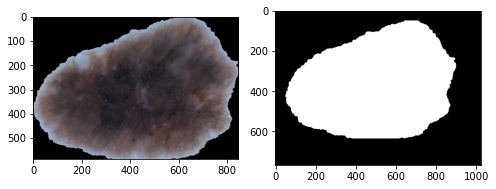

In [9]:
IM = 'ISIC_0000000'
image = plt.imread(df['train']['path']+IMG+IM+'.jpg')
seg = plt.imread(df['train']['path']+SEG+IM+'_segmentation.png')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
axes[0].imshow(image)
axes[1].imshow(seg, cmap='gray')
fig.tight_layout()

### Showing how the zoom function works

This shows how the image was cropped so that the border is cut to the edges of the lesion, resulting in the cropped image of the lesion seen above on the left.

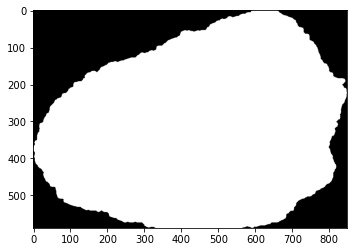

In [10]:
plt.imshow(zoom(seg), cmap='gray')
plt.show()

### Convert an image to grayscale

This shows how the rgb2gray function works to convert an image to grayscale.

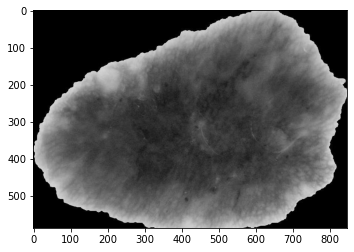

In [11]:
plt.imshow(rgb2gray(image), cmap='gray')

### VIsualize the masker function

This function was written to create our own segmentation images. When the image has been masked with a segmentation image already, the function outputs differently. Since the images in this repository have all already been masked, it is not as clear to see how this functino would work. In addition, since we already had access to segmentation images, we did not further explore optimization of this technique for large amounts of images.

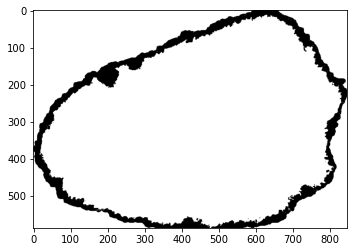

In [12]:
plt.imshow(masker(image,140), cmap='gray')

### Visualize output of function for Area and Perimeter

This shows the output of the function that shows area and perimeter of a lesion, as well as a visual display of the perimeter of the lesion.

Area: 364956.0
Perimeter: 2586.8855685242374


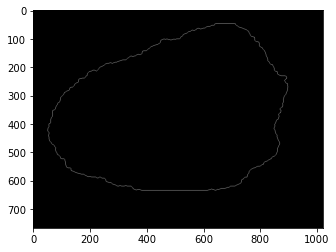

In [13]:
area, perimeter = measure_area_perimeter(seg)
print(f'Area: {area}\nPerimeter: {perimeter}')

struct_el = morphology.disk(1)
mask_eroded = morphology.binary_erosion(seg, struct_el)
image_perimeter = seg - mask_eroded
plt.imshow(image_perimeter, cmap='gray')
plt.show()

### Output of the cuts function

The output of this function is then used in the test_symmetry function.

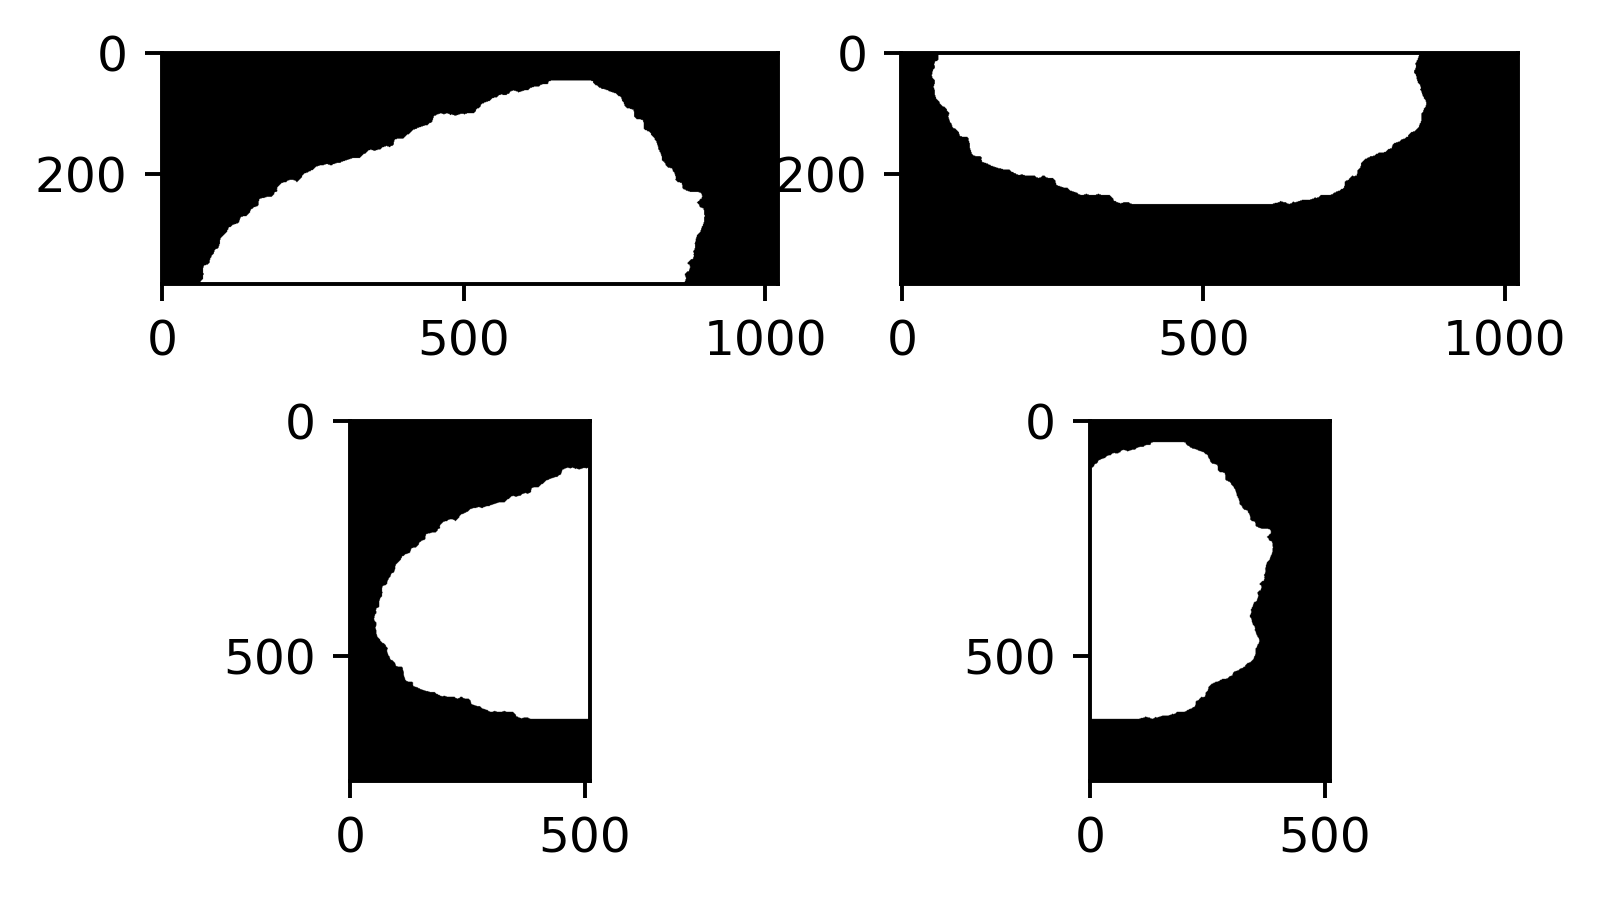

In [14]:
u,d,l,r = cuts(seg)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(5,3), dpi=350)
ax1.imshow(u, cmap='gray')
ax2.imshow(d, cmap='gray')
ax3.imshow(l, cmap='gray')
ax4.imshow(r, cmap='gray')

plt.show()

### Result of the test_symmetry function

In [15]:
test_symmetry(seg)

0.7351783518813269

This lesion shows a 73.51% symmetry, which lines up well with the visual symmetry of the image.

# Feature Extraction

We proceed to extract features of interest for our predictive model

#### Asymmetry

To test for asymmetry we run a function to calculate a score based on how similar an image is when cut horizontally and vertically. We assign a score between 0 (non asymmetric) and 1 (totally asymmetric) for both cuts, and we take the average to convey a unique value.

In [16]:
# We perform a test on a black circle, where it's symmetry should be close to 1
test_circle = plt.imread('./data/test-black-circle.png') # Load the circle test
test_circle = test_circle[:,:,0]
print(f'Symmetry test for black circle: {test_symmetry(test_circle):.2%}')

Symmetry test for black circle: 99.99%


In [17]:
DATASET = input("Which dataset to calculate? [train, validation, test] ")
if DATASET.lower() not in ['train', 'validation', 'test']:
    print('OPERATION CANCELLED')
else:
    data = df[DATASET]['label']

    DoBatch = int(input("How many batches? "))
    if DoBatch > data.shape[0]:
        DoBatch = data.shape[0]
    batch = int(input("Do batch # "))
    assert batch <= DoBatch, "Wrong Batch #"

    WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

    REWRITE = input("Do you wish to overwrite the /symmetry.csv file?: (Yes/No) ")
    print("\n----- PLEASE BE PATIENT -----\n")


    length = data.shape[0] // DoBatch
    start = length * (batch - 1)
    end = length * (batch)

    if WARN.lower().startswith("y"):
        symmetry = {}
        i = 1
        for ix, row in data[start:end].iterrows():
            file_path = df[DATASET]['path'] + SEG + str(ix) + "_segmentation.png"
            image = plt.imread(file_path)

            ptg = round(i / length,2)
            print(f'\rCalculating symmetry: {ptg:.2%}', end='\r')
            symmetry[ix] = test_symmetry(image)
            i += 1
            %xdel image
    else: print("OPERATION CANCELLED")

    if REWRITE.lower().startswith("y"):
        with open(df[DATASET]['path'] + FEAT + f'symmetry_{str(batch)}.csv', 'w') as outfile:
            outfile.write('image_id'+','+'symmetry'+'\n')
            for k, v in symmetry.items():
                line = k +','+str(v)
                outfile.write(line+'\n')

Which dataset to calculate? [train, validation, test] 
OPERATION CANCELLED


#### Border (Compactness method)

To test for border smoothness we use the compactness method. Compactness is defined as the ratio of the
area of an object to the area of a circle with the same perimeter.
The measure takes a maximum value of 1 for a circle.

In [18]:
# We perform a test on a black circle, where it's compactness should be close to 1
circle_area, circle_perimeter = measure_area_perimeter(test_circle)
circle_compactness = (4* math.pi * circle_area) / (circle_perimeter**2)
print(f'Compactness test for black circle: {circle_compactness:.2%}')

Compactness test for black circle: 90.55%


In [19]:
DATASET = input("Which dataset to calculate? [train, validation, test] ")
if DATASET.lower() not in ['train', 'validation', 'test']:
    print('OPERATION CANCELLED')
else:
    data = df[DATASET]['label']

    DoBatch = int(input("How many batches? "))
    if DoBatch > data.shape[0]:
        DoBatch = data.shape[0]
    batch = int(input("Do batch # "))
    assert batch <= DoBatch, "Wrong Batch #"

    WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

    REWRITE = input("Do you wish to overwrite the /compactness.csv file?: (Yes/No) ")
    print("\n----- PLEASE BE PATIENT -----\n")


    length = data.shape[0] // DoBatch
    start = length * (batch - 1)
    end = length * (batch)

    if WARN.lower().startswith("y"):
        compactness = {}
        i = 1
        for ix, row in data[start:end].iterrows():
            file_path = df[DATASET]['path'] + SEG + str(ix) + "_segmentation.png"
            image = plt.imread(file_path)

            ptg = round(i / length,2)
            print(f'\rCalculating compactness: {ptg:.2%}', end='\r')
            area, per = measure_area_perimeter(image)
            compactness[ix] = (4* math.pi * area) / (per**2)
            i += 1
    else: print("OPERATION CANCELLED")

    if REWRITE.lower().startswith("y"):
        with open(df[DATASET]['path'] + FEAT + f'compactness_{str(batch)}.csv', 'w') as outfile:
            outfile.write('image_id'+','+'compactness'+'\n')
            for k, v in compactness.items():
                line = k +','+str(v)
                outfile.write(line+'\n')

Which dataset to calculate? [train, validation, test] 
OPERATION CANCELLED


#### Color

In order to evaluate the difference in lesion colors, we take the standard deviation for each of the 3 RGB channels of the cropped image (to reduce noise), and then we average the 3 deviations to obtain a unique value.

In [20]:
DATASET = input("Which dataset to calculate? [train, validation, test] ")
if DATASET.lower() not in ['train', 'validation', 'test']:
    print('OPERATION CANCELLED')
else:
    data = df[DATASET]['label']

    DoBatch = int(input("How many batches? "))
    if DoBatch > data.shape[0]:
        DoBatch = data.shape[0]
    batch = int(input("Do batch # "))
    assert batch <= DoBatch, "Wrong Batch #"

    WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

    REWRITE = input("Do you wish to overwrite the /color_deviation.csv file?: (Yes/No) ")
    print("\n----- PLEASE BE PATIENT -----\n")


    length = data.shape[0] // DoBatch
    start = length * (batch - 1)
    end = length * (batch)

    if WARN.lower().startswith("y"):
        color_deviation = {}
        i = 1
        for ix, row in data[start:end].iterrows():
            file_path = df[DATASET]['path'] + IMG + str(ix) + ".jpg"
            image = plt.imread(file_path)

            ptg = round(i / length,2)
            print(f'\rCalculating color deviation: {ptg:.2%}', end='\r') 
            color_deviation[ix] = color_std(image)
            i += 1
    else: print("OPERATION CANCELLED")

    if REWRITE.lower().startswith("y"):
        with open(df[DATASET]['path'] + FEAT + f'color_deviation{str(batch)}.csv', 'w') as outfile:
            outfile.write('image_id'+','+'color_deviation'+'\n')
            for k, v in color_deviation.items():
                line = k +','+str(v)
                outfile.write(line+'\n')

Which dataset to calculate? [train, validation, test] 
OPERATION CANCELLED


### Aggregating features to datasets

We will now add the recently extracted features to our main dataset

In [21]:
feat_list = ['symmetry', 'compactness', 'color_deviation']
for dataset in df.keys():
    for feat in feat_list:
        symmetry = pd.read_csv(df[dataset]['path'] + FEAT + 'symmetry.csv', index_col='image_id') 
        compactness = pd.read_csv(df[dataset]['path'] + FEAT + 'compactness.csv', index_col='image_id')
        color_deviation = pd.read_csv(df[dataset]['path'] + FEAT + 'color_deviation.csv', index_col='image_id')
        df[dataset]['features'] = symmetry.merge(compactness, how = 'inner', on = 'image_id')\
        .merge(color_deviation, how = 'inner', on = 'image_id')


In [22]:
df['train']['features'].head()

,symmetry,compactness,color_deviation
image_id,,,
ISIC_0000000,0.735178,0.685324,40.695378
ISIC_0000001,0.872937,0.587657,28.082534
ISIC_0000002,0.726637,0.508980,36.025267
ISIC_0000003,0.826583,0.684563,36.888846
ISIC_0000004,0.785273,0.834540,41.525334


### Analysis of Features

#### Feature Scaling

As our features Symmetry and Compactness have a metric between zero and one, we will only scale the color deviation feature to match the same range as the others.

In [23]:
for dataset in df.keys():
    scaled_color_deviation = []
    to_scale = df[dataset]['features'].color_deviation
    for i in to_scale.iteritems():
        new_x = (i[1] - np.min(to_scale)) /\
        (np.max(to_scale) - np.min(to_scale))
        scaled_color_deviation.append(new_x)
    df[dataset]['features'].color_deviation = scaled_color_deviation
    

In [24]:
# Example of Dataframe with scaling
df['train']['features'].head()

,symmetry,compactness,color_deviation
image_id,,,
ISIC_0000000,0.735178,0.685324,0.545642
ISIC_0000001,0.872937,0.587657,0.319064
ISIC_0000002,0.726637,0.508980,0.461748
ISIC_0000003,0.826583,0.684563,0.477261
ISIC_0000004,0.785273,0.834540,0.560552


#### Creating Sets

We create a "training set" by merging the collected features with the labels for further analysis.

In [25]:
train_set = df['train']['label'].merge(df['train']['features'], how = 'inner', on = 'image_id')
train_set.drop('seborrheic_keratosis', axis= 1, inplace=True)


In [26]:
train_set.loc[train_set.melanoma == 1, 'melanoma'] = "Melanoma" # Change labels from float to String
train_set.loc[train_set.melanoma == 0, 'melanoma'] = "Non-Melanoma"
train_set.columns = ['label'] + list(train_set.columns)[1:] # Re order columns to match all sets

#### Resampling

Since our training set contains 5 times more Non-Melanoma observations than "Melanoma", we resample to achieve 1/3 of positive "Melanoma" labels and train a more balanced dataset.

In [27]:
melanoma = train_set.loc[train_set.label == "Melanoma"]
n = train_set.shape[0]//2 - melanoma.shape[0] # We want 1/3 to be melanoma
resample_melanoma = resample(melanoma, n_samples=n)
train_set_rs = train_set.append(resample_melanoma)
print(f'The new training set contains now {train_set_rs[train_set_rs.label == "Melanoma"].shape[0]}\
 Melanoma observations and {train_set_rs[train_set_rs.label != "Melanoma"].shape[0]}\
 non Melanoma observations.')

The new training set contains now 966 Melanoma observations and 1578 non Melanoma observations.


#### Plotting features

We plot our features by two with their correspondant kernel density curves to detect patterns.

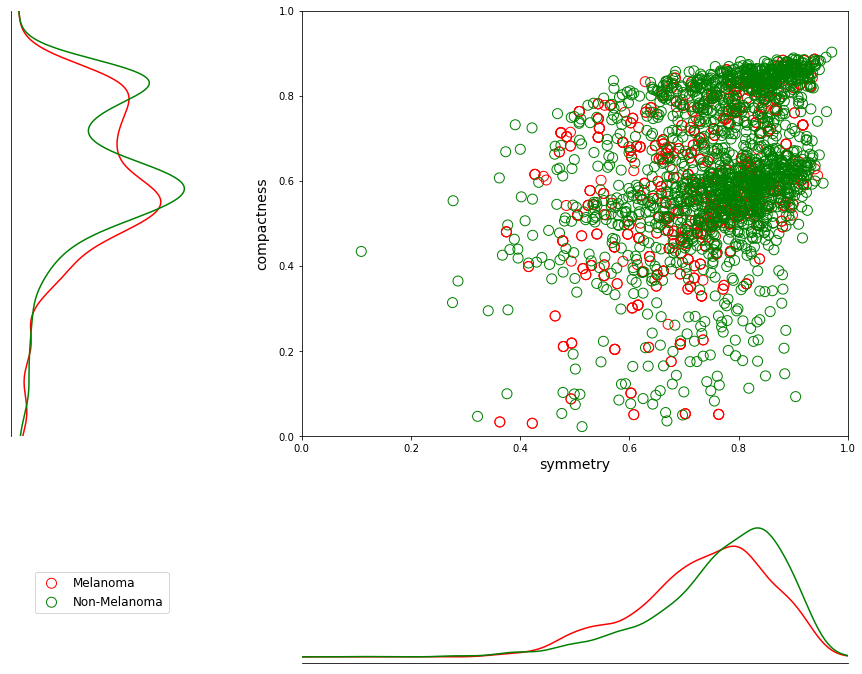

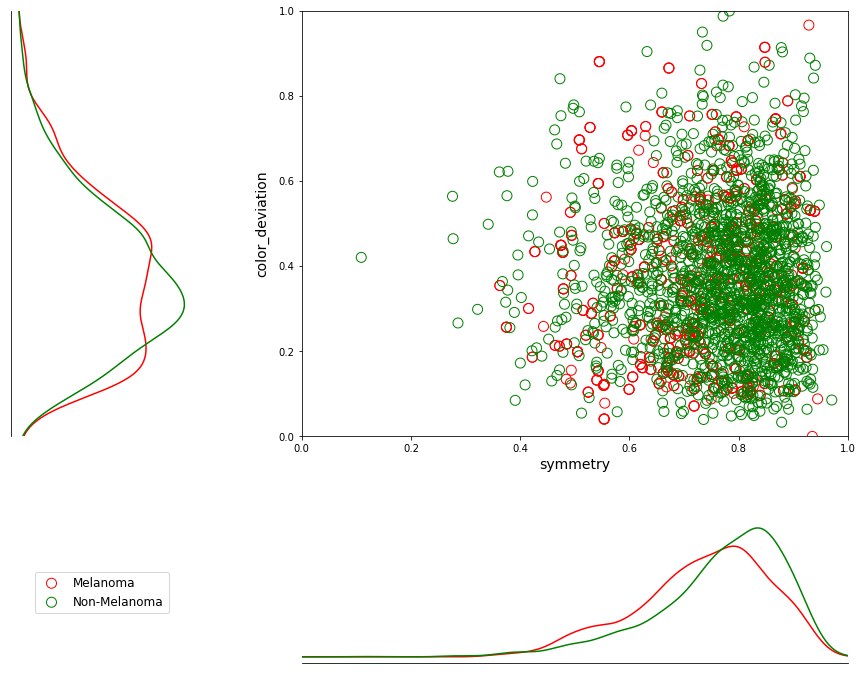

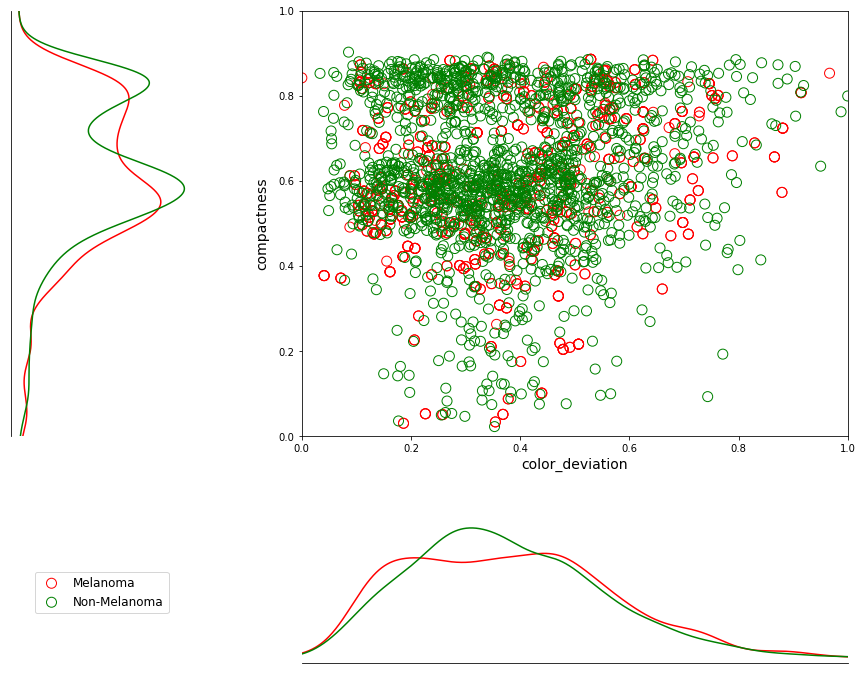

In [28]:
labels = ['Melanoma', 'Non-Melanoma']
cl = ['r','g'] # Colors

feat_iter = feat_list.copy()
for f1 in feat_iter:
    for f2 in feat_iter:
        if f1 != f2:
        
            # Set up 4 subplots and aspect ratios as axis objects using GridSpec:
            gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
            # Add space between scatter plot and KDE plots to accommodate axis labels:
            gs.update(hspace=0.3, wspace=0.3)

            fig = plt.figure(figsize=(15,12)) 
            fig.patch.set_facecolor('white')

            ax = plt.subplot(gs[0,1]) # Instantiate scatter plot area and axis range
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xlabel(f1, fontsize = 14)
            ax.set_ylabel(f2, fontsize = 14)
            ax.yaxis.labelpad = 10 # adjust space between x and y axes and their labels if needed

            axl = plt.subplot(gs[0,0], sharey=ax) # Instantiate left KDE plot area
            axl.get_xaxis().set_visible(False) # Hide tick marks and spines
            axl.get_yaxis().set_visible(False)
            axl.spines["right"].set_visible(False)
            axl.spines["top"].set_visible(False)
            axl.spines["bottom"].set_visible(False)

            axb = plt.subplot(gs[1,1], sharex=ax) # Instantiate bottom KDE plot area
            axb.get_xaxis().set_visible(False) # Hide tick marks and spines
            axb.get_yaxis().set_visible(False)
            axb.spines["right"].set_visible(False)
            axb.spines["top"].set_visible(False)
            axb.spines["left"].set_visible(False)

            axc = plt.subplot(gs[1,0]) # Instantiate legend plot area
            axc.axis('off') # Hide tick marks and spines

            # For each category in the list...
            for l in range(len(labels)):
            # Create a sub-table containing only entries matching current category:
                st = train_set_rs.loc[train_set_rs['label'] == labels[l]]
                # Select first two columns of sub-table as x and y values to be plotted:
                x = st[f1].values
                y = st[f2].values

                # Plot data for each categorical variable as scatter and marginal KDE plots:    
                ax.scatter(x,y, color='none', s=100, edgecolor= cl[l], label = labels[l])

                kde = stats.gaussian_kde(x)
                xx = np.linspace(0, 1, 1000)
                axb.plot(xx, kde(xx), color=cl[l])

                kde = stats.gaussian_kde(y)
                yy = np.linspace(0, 1, 1000)
                axl.plot(kde(yy), yy, color=cl[l])

            # Copy legend object from scatter plot to lower left subplot and display:
            # NB 'scatterpoints = 1' customises legend box to show only 1 handle (icon) per label 
            handles, labels = ax.get_legend_handles_labels()
            axc.legend(handles, labels, scatterpoints = 1, loc = 'center', fontsize = 12)

            plt.show()
    feat_iter.remove(f1)

In [29]:
positive = train_set_rs.loc[train_set_rs.label == "Melanoma"]
negative = train_set_rs.loc[train_set_rs.label == "Non-Melanoma"]

We plot now a 3D scatterplot with all 3 features distinguishing by label. 

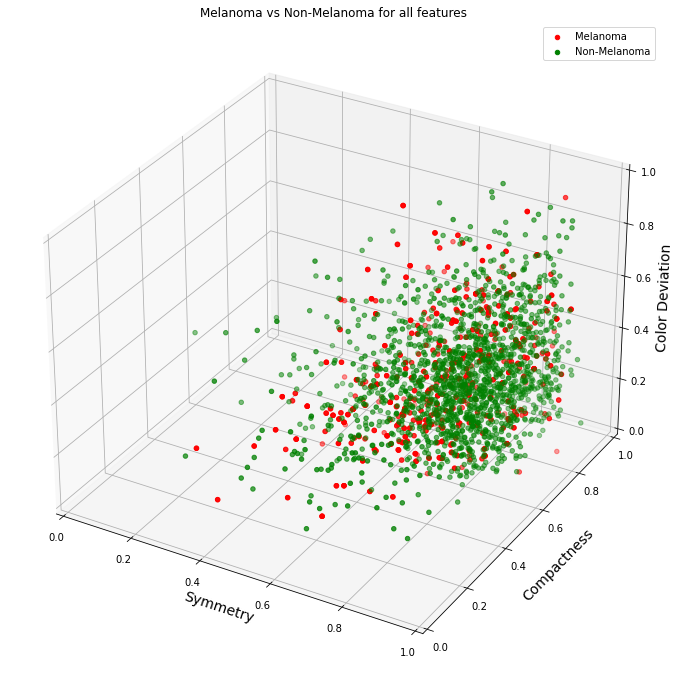

In [30]:
fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection='3d')
ax.scatter(positive.symmetry.values, positive.compactness.values, positive.color_deviation.values, \
           color='r', label='Melanoma')
ax.scatter(negative.symmetry.values, negative.compactness.values, negative.color_deviation.values, \
           color='g', label="Non-Melanoma")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel("Symmetry", fontsize = 14)
ax.set_ylabel("Compactness", fontsize = 14)
ax.set_zlabel("Color Deviation", fontsize = 14)
ax.yaxis.labelpad = 10 # adjust space between x and y axes and their labels if needed
plt.title("Melanoma vs Non-Melanoma for all features")
ax.legend()

Finally we take a closer look at the distributions of the features.

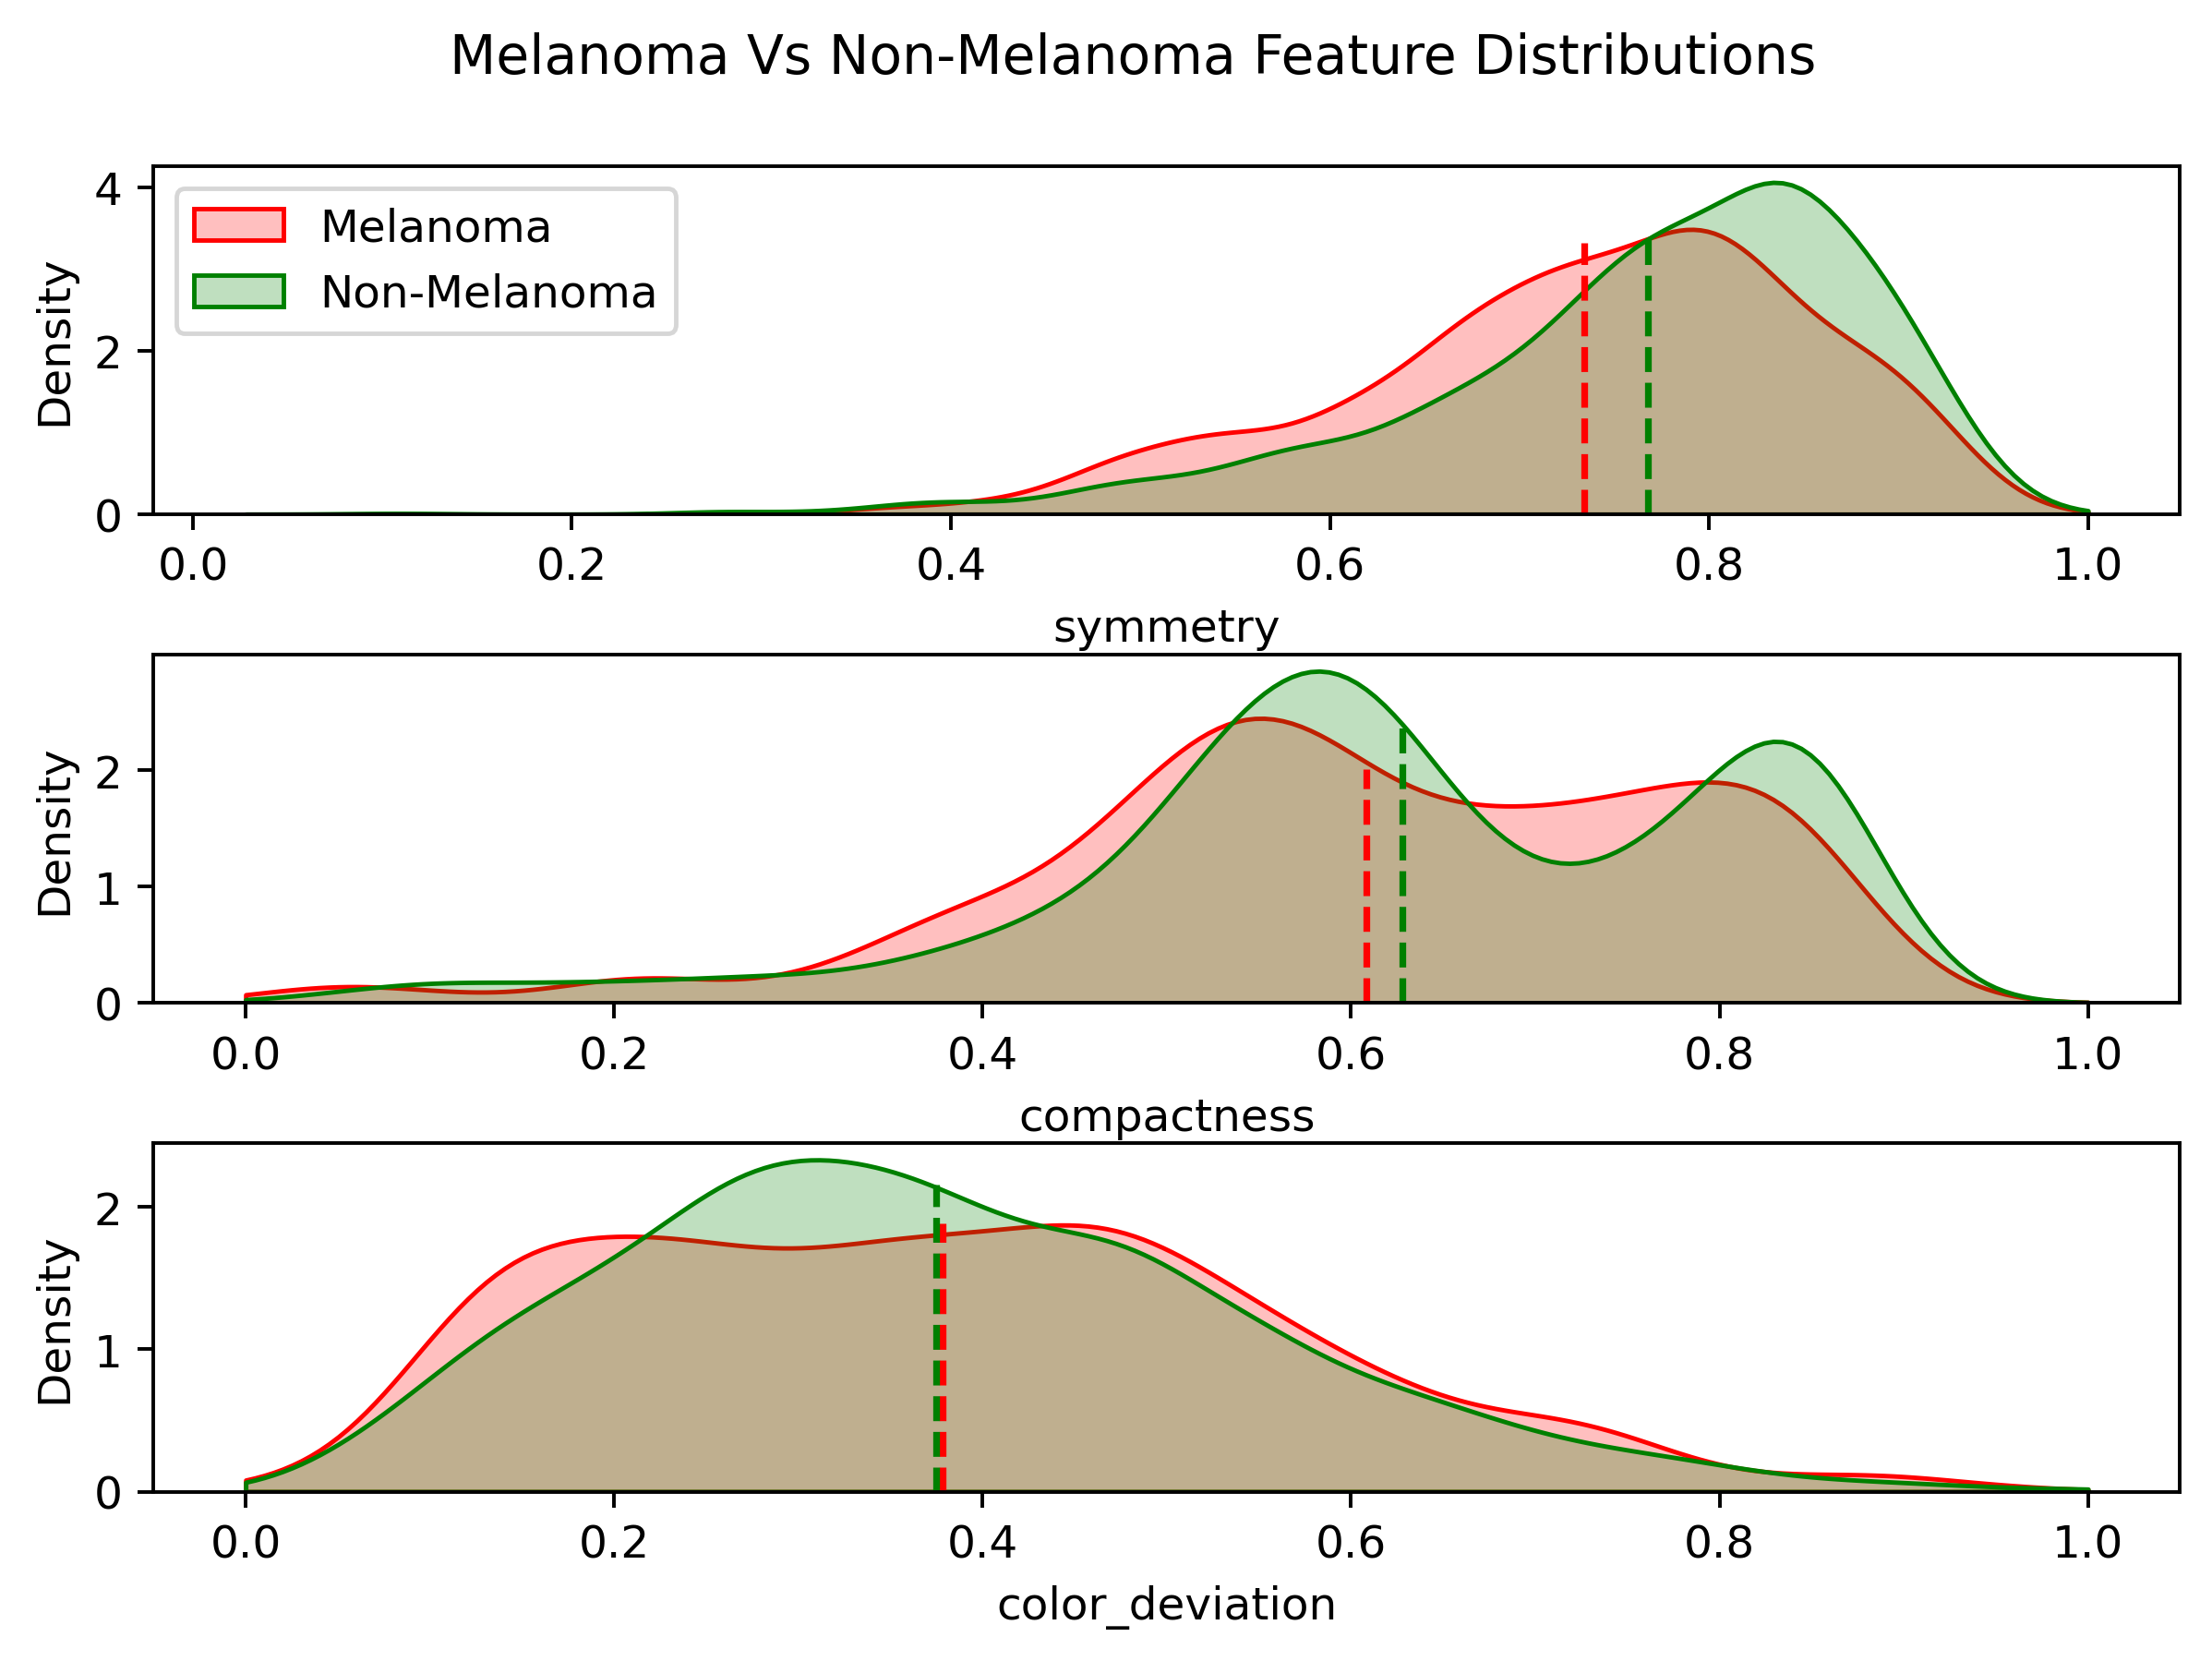

In [31]:
fig, axs = plt.subplots(3,1, figsize=(7,5), dpi=350)
fig.suptitle("Melanoma Vs Non-Melanoma Feature Distributions")
fig.tight_layout()

sns.kdeplot(x = 'symmetry', data=positive, cumulative= False, shade=True, clip=(0,1), color='r',label="Melanoma",ax=axs[0])
sns.kdeplot(x = 'symmetry', data=negative, cumulative= False, shade=True, clip=(0,1), color='g',label="Non-Melanoma",ax=axs[0])
axs[0].axvline(np.mean(positive.symmetry), ymin= 0, ymax= 0.78, color='r', linestyle = 'dashed')
axs[0].axvline(np.mean(negative.symmetry), ymin= 0, ymax= 0.80, color='g', linestyle = 'dashed')
axs[0].legend(loc="upper left")

sns.kdeplot(x = 'compactness', data=positive, cumulative= False, shade=True, clip=(0,1), color='r',label="Melanoma",ax=axs[1])
sns.kdeplot(x = 'compactness', data=negative, cumulative= False, shade=True, clip=(0,1), color='g',label="Non-Melanoma",ax=axs[1])
axs[1].axvline(np.mean(positive.compactness), ymin= 0, ymax= 0.67, color='r', linestyle = 'dashed')
axs[1].axvline(np.mean(negative.compactness), ymin= 0, ymax= 0.80, color='g', linestyle = 'dashed')
#axs[1].legend(loc="upper left")

sns.kdeplot(x = 'color_deviation', data=positive, cumulative= False, shade=True, clip=(0,1), color='r',label="Melanoma",ax=axs[2])
sns.kdeplot(x = 'color_deviation', data=negative, cumulative= False, shade=True, clip=(0,1), color='g',label="Non-Melanoma",ax=axs[2])
axs[2].axvline(np.mean(positive.color_deviation), ymin= 0, ymax= 0.77, color='r', linestyle = 'dashed')
axs[2].axvline(np.mean(negative.color_deviation), ymin= 0, ymax= 0.88, color='g', linestyle = 'dashed')
#axs[2].legend(loc="upper right")

plt.show()
#plt.savefig("./reports/figures/densitySubplots.png")

From the plots is difficult to see any correlation. We will take each feature by pairs and see if they are correlated.

In [34]:
print('For Melanoma, the features have the following correlation coefficients:\n')
feat_iter = feat_list.copy()
for f1 in feat_iter:
    for f2 in feat_iter:
        if f1 != f2:
            corr = np.corrcoef(positive[f1], positive[f2])
            print(f'Corr. {f1} and {f2}: {corr[0,1]:.2%}')
    feat_iter.remove(f1)
    
print('\nFor Non-Melanoma, the features have the following correlation coefficients:\n')
feat_iter = feat_list.copy()
for f1 in feat_iter:
    for f2 in feat_iter:
        if f1 != f2:
            corr = np.corrcoef(negative[f1], negative[f2])
            print(f'Corr. {f1} and {f2}: {corr[0,1]:.2%}')
    feat_iter.remove(f1)

For Melanoma, the features have the following correlation coefficients:

Corr. symmetry and compactness: 39.24%
Corr. symmetry and color_deviation: 7.08%
Corr. color_deviation and compactness: 16.89%

For Non-Melanoma, the features have the following correlation coefficients:

Corr. symmetry and compactness: 34.78%
Corr. symmetry and color_deviation: -3.95%
Corr. color_deviation and compactness: 4.48%


# Models

We first create the set with features and labels for validation and test data.

In [35]:
# For Validation Data
validation_set = df['validation']['label'].merge(df['validation']['features'],\
                                                 how = 'inner', on = 'image_id')

# For Test Data
test_set = df['test']['label'].merge(df['test']['features'], how = 'inner', on = 'image_id')


In [36]:
labels = []
for ix, row in validation_set.iterrows():
    if row['melanoma'] == 1.0:
        labels.append("Melanoma")
    else:
        labels.append("Non-Melanoma")
        
validation_set['label'] = labels
validation_set.drop("melanoma", axis=1, inplace=True)
validation_set.drop("seborrheic_keratosis", axis=1, inplace=True)  

labels = []
for ix, row in test_set.iterrows():
    if row['melanoma'] == 1.0:
        labels.append("Melanoma")
    else:
        labels.append("Non-Melanoma")
        
test_set['label'] = labels
test_set.drop("melanoma", axis=1, inplace=True)
test_set.drop("seborrheic_keratosis", axis=1, inplace=True)

In [37]:
# We move the label column to the last place to match the other datasets
cols = list(train_set_rs.columns)
cols = cols[1:] + [cols[0]]
train_set_rs = train_set_rs[cols]

In [38]:
train_set_rs.head()

,symmetry,compactness,color_deviation,label
image_id,,,,
ISIC_0000000,0.735178,0.685324,0.545642,Non-Melanoma
ISIC_0000001,0.872937,0.587657,0.319064,Non-Melanoma
ISIC_0000002,0.726637,0.508980,0.461748,Melanoma
ISIC_0000003,0.826583,0.684563,0.477261,Non-Melanoma
ISIC_0000004,0.785273,0.834540,0.560552,Melanoma


#### Data splitting

In [39]:
# For Training Data
X_train = train_set_rs.iloc[:,:-1].reset_index(drop=True).values
y_train = train_set_rs.iloc[:,-1].reset_index(drop=True).values

# For Validation Data
X_valid = validation_set.iloc[:,:-1].reset_index(drop=True).values
y_valid = validation_set.iloc[:,-1].reset_index(drop=True).values

# For Test Data
X_test = test_set.iloc[:,:-1].reset_index(drop=True).values
y_test = test_set.iloc[:,-1].reset_index(drop=True).values

### K-Nearest Neighbors

#### Selecting best K

We will try the model on a different range of Ks to find the optimal one. Since we are interested in a precautory diagnosis for Melanoma, we would try to achieve the best recall score for the "Melanoma" label.<br>
Note: $$Recall = \frac{tp}{(tp+fn)}$$
<br>
Where "tp" is true positive and "fn" is false negative.

In [83]:
scores_KNN = []

# Calculating score for K values between 3 and 40
for i in range(3, 40):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train, y_train)
    pred_i = KNN.predict(X_valid)
    scores_KNN.append(recall_score(y_valid, pred_i, pos_label="Melanoma", average='binary'))

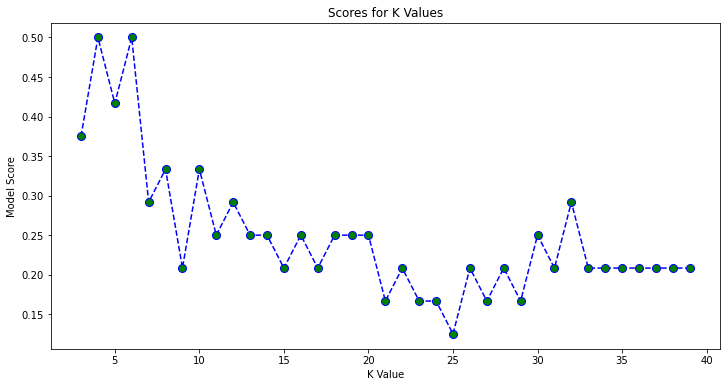

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(range(3, 40), scores_KNN, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8)
plt.title('Scores for K Values')
plt.xlabel('K Value')
plt.ylabel('Model Score');

In [87]:
best_k = [i+3 for i, x in enumerate(scores_KNN) if x == max(scores_KNN)]
best_k[0] # Out of all possible k neighbors that return the best recall, we want the smallest.

4

#### Model fitting

In [86]:
KNN = KNeighborsClassifier(n_neighbors=best_k[0]) # We fit the model with our optimal k number
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

#### Model prediction on Validation Data

In [77]:
y_pred_KNN = KNN.predict(X_valid)

In [78]:
print(classification_report(y_valid, y_pred_KNN))
print(f'Overall Model Accuracy: {accuracy_score(y_valid, y_pred_KNN):.2%}')

              precision    recall  f1-score   support

    Melanoma       0.21      0.50      0.30        24
Non-Melanoma       0.85      0.60      0.71       111

    accuracy                           0.59       135
   macro avg       0.53      0.55      0.50       135
weighted avg       0.74      0.59      0.63       135

Overall Model Accuracy: 58.52%


PRECISION: is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as the ratio of true positives to the sum of true and false positives.

TP – True Positives
FP – False Positives

Precision – Accuracy of positive predictions.
Precision = TP/(TP + FP)

Our model achieved a precision of 0.16 for Melanoma and 0.80 for Non-Melanoma, with a joint accuracy of 73.50 %.

---------

RECALL: is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

FN – False Negatives

Recall: Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

Our model did not perform specially well on predicting Melanoma instances.

---------

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

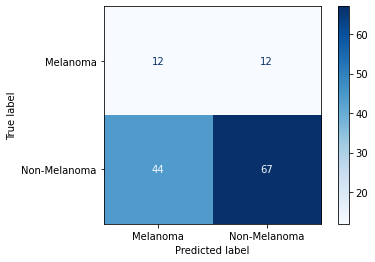

In [82]:
plot_confusion_matrix(KNN, X_valid, y_valid,
                                 display_labels=['Melanoma', "Non-Melanoma"],
                                 cmap=plt.cm.Blues);

### Decision Tree

In [88]:
DT = tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

In [89]:
y_pred_DT = DT.predict(X_valid)

In [90]:
print(classification_report(y_valid, y_pred_DT))
print(f'Overall Model Accuracy: {accuracy_score(y_valid, y_pred_DT):.2%}')

              precision    recall  f1-score   support

    Melanoma       0.17      0.17      0.17        24
Non-Melanoma       0.82      0.82      0.82       111

    accuracy                           0.70       135
   macro avg       0.49      0.49      0.49       135
weighted avg       0.70      0.70      0.70       135

Overall Model Accuracy: 70.37%


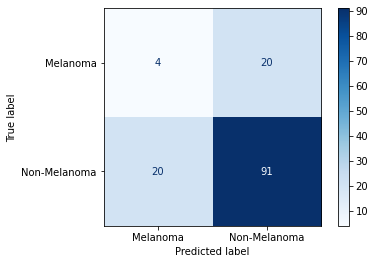

In [91]:
plot_confusion_matrix(DT, X_valid, y_valid,
                                 display_labels=['Melanoma', "Non-Melanoma"],
                                 cmap=plt.cm.Blues)

Our Decision Tree model performs a little better than the KNN, with 19% of true melanomas detected and 81% of non-melanoma correctly detected.